### 1. 导入完成主成分分析和聚类所需要的包

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from A06_PCA import DimensionReduce, show_scree_plot, show_correlation_plot
from A07_KMeans import Clustering
from A06_StandardScaler import Standard
from ShowClusterScatter import show_class_result
from ShowSilhouette import show_silhouette_plot
import warnings
import joblib

warnings.filterwarnings('ignore')

plt.rc('font', family='Times New Roman')


### 2 对刹车事件中的加速度特征进行标准化，并返回标准化后的结果scaler_acc_X

In [10]:
data = pd.read_excel('../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_主成分结果.xlsx')
# 提取减速事件的减速度特征指标进行标准化
dec_data = data[data['logo'] == '刹车事件'].reset_index(drop=True)
dec_X = dec_data[['max_dec_lon', 'mean_dec_lon', 'std_dec_lon',
                  'max_jerk', 'mean_jerk', 'std_jerk']]
dec_ss = Standard(dec_X)
scaler_dec_X = dec_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(dec_ss, '../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_数据标准化模型.pkl')


['../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_数据标准化模型.pkl']

In [11]:
scaler_dec_X.columns = ['ss_'+i for i in scaler_dec_X.columns.to_list()]
dec_data = pd.concat([dec_data, scaler_dec_X], axis=1)

### 3 对减速特征进行进行降维，追加到原始速度中

In [12]:
# 创建减速事件PCA降维类
dec_dr = DimensionReduce(scaler_dec_X,n_pc=2)
dec_tve = dec_dr.calc_total_variance_explain()
dec_tve.to_excel('../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_主成分总解释方差.xlsx', index=False)

dec_rc_load = dec_dr.calc_RC_loadings()
dec_rc_load.to_excel('../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_主成分旋转载荷.xlsx', index=True)

dec_data = pd.concat([dec_data,dec_dr.pcs],axis=1)
dec_data = dec_data.rename(columns={'PC1': 'dec_PC1', 'PC2': 'dec_PC2'})
dec_data.to_excel('../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_主成分结果.xlsx', index=False)
# 速度聚类模型保存
joblib.dump(dec_dr,'../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_降维模型.pkl')


['../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_降维模型.pkl']

### 4 基于标准化的减速特征进行二级聚类，返回聚类轮廓图和聚类中心点

完成0聚类
The average silhouette score of all samples:  0.49705323440236454
The average silhouette score of cluster 0 : 0.62
The average silhouette score of cluster 1 : 0.35
The average silhouette score of cluster 2 : 0.17
完成1聚类
The average silhouette score of all samples:  0.43570702423166524
The average silhouette score of cluster 0 : 0.53
The average silhouette score of cluster 1 : 0.38
The average silhouette score of cluster 2 : 0.20


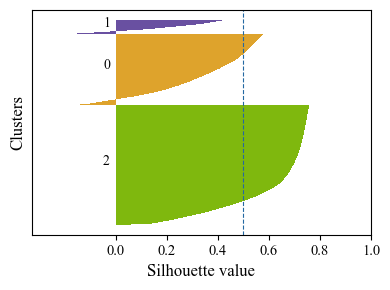

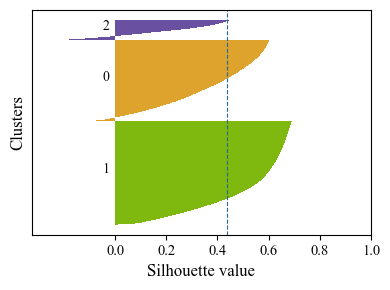

In [13]:
dec_data = pd.read_excel('../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_主成分结果.xlsx')
all_dec_event = []
for i in range(2):
    dec_event = dec_data[dec_data['v_label'] == i]
    dec_clus = Clustering(dec_event[scaler_dec_X.columns.to_list(
    )], calc_best_cluster_flag=False, best_cluster=3)
    print('完成{}聚类'.format(i))
    if dec_clus.calc_best_cluster_flag:
        dec_clus.show_silhouette_clusters()
        print('速度{}轮廓系数：{}'.format(i, dec_clus.silhouette_scores))
        plt.savefig(
            '../GpsFigure/两阶段聚类_New/二阶段刹车聚类/speed{}_减速相关指标_聚类数与轮廓系数图.pdf'.format(i))
    dec_event['dec_label'] = dec_clus.best_labels
    all_dec_event.append(dec_event)
    # 绘制加速、减速事件轮廓系数图
    cls_list = list(dec_event[['max_dec_lon', 'dec_label']].groupby(
        'dec_label').mean().sort_values(by='max_dec_lon').index)
    show_silhouette_plot(dec_event, x_cols=['dec_PC1', 'dec_PC2'], y_col='dec_label',
                         num_cls=3, cls_list=cls_list, colors=['#7fb80e', '#dea32c', '#6950a1'])
    plt.savefig(
        '../GpsFigure/两阶段聚类_New/二阶段刹车聚类/speed{}_减速相关指标_最优聚类轮廓图.png'.format(i), dpi=1200)
    # 求解聚类中心
    centers = dec_clus.best_kmeans.cluster_centers_
    x_centers = dec_ss.scaler.inverse_transform(centers)
    x_centers = pd.DataFrame(x_centers, columns=dec_X.columns)
    x_centers.to_excel(
        '../GpsData/两阶段聚类_New/二阶段刹车聚类/speed{}_减速相关指标_聚类中心点.xlsx'.format(i), index=False)
all_dec_event = pd.concat(all_dec_event, axis=0).reset_index(drop=True)
all_dec_event.to_excel(
    '../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_聚类结果.xlsx', index=False)


### 5 可视化二阶段减速度聚类结果散点图

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rc('font',family='Times New Roman')

def show_class_result(data:pd.DataFrame, PC_list:list, label:str, pca, num_cls:int, feature_num:int, arrow_text_list:list, xy_labels:list, 
                      cls_list:list, cls_legend:list, cls_colors = ['#bb505d','#7fb80e','#4e72b8'], vector_scale:float = 1):
    """绘制降维后的散点图
    Args:
        data (pd.DataFrame): 需要绘制散点的数据集
        PC_list (list): 散点图x,y轴对应数据data中的列名
        label (str): 散点图分类标签对应数据data中的列名
        pca (_type_): 降维散点图中所使用的pca模型
        num_cls (_int_): 散点分类的个数
        feature_num (int): 降维前的数据原始特征数
        arrow_text_list (list): 原始特征的标签
        xy_labels (list): 绘图坐标轴的标题
        cls_list (list): 分类标签的列表
        cls_legend (list): 绘图中所使用的分类图例
        cls_colors (list, optional): 散点分类所使用的颜色. Defaults to ['#bb505d','#7fb80e','#4e72b8'].
        vector_scale (float, optional): 矢量图缩放比例. Defaults to 1.
    """    
    fig,ax = plt.subplots(figsize=(4,3))

    # 绘制原点的水平线和垂直线
    ax.axhline(y=0, color='#3e4145', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='#3e4145', linestyle='--', linewidth=0.8)
    
    # 可视化分类结果
    # 按照label列分组，将不同的标签对应的数据分别绘制在散点图上，并使用不同颜色表示
    marker_list = ['o', '^', 'x', 'D']
    for i in range(num_cls):
        x = data.loc[data[label] == cls_list[i], PC_list[0]]
        y = data.loc[data[label] == cls_list[i], PC_list[1]]
        plt.scatter(x, y, c=cls_colors[i], label=cls_legend[i], marker=marker_list[i], s=1, alpha=0.5)
    
    # 绘制原始特征的向量线
    features = np.eye(feature_num)
    feature_vectors = pca.transform(features)
    for i, (x, y) in enumerate(feature_vectors[:,[0,1]]):
        plt.arrow(0, 0, x*feature_num*vector_scale, y*feature_num*vector_scale, color='#130c0e',width=0.01, head_width=0.3, 
                head_length=0.3, length_includes_head=True, zorder=100)
        plt.text(x*feature_num*vector_scale, y*feature_num*vector_scale, arrow_text_list[i], fontsize=10, color='k')
    
    # 设置轴标题
    plt.xlabel(xy_labels[0], fontsize=12)
    plt.ylabel(xy_labels[1], fontsize=12)
    

    plt.xlim([-7.5,20])
    plt.ylim([-5,15])
    
    # 设置轴刻度属性
    plt.xticks(fontsize=10.5)
    plt.yticks(fontsize=10.5)
    
    # 设置图例
    plt.legend(title='Clusters', fontsize=10.5, loc='upper right')
    plt.tight_layout()
    

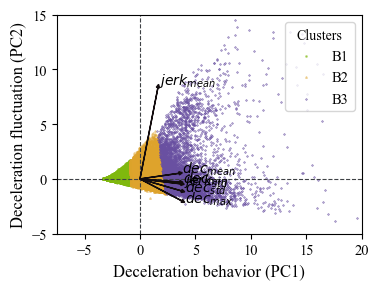

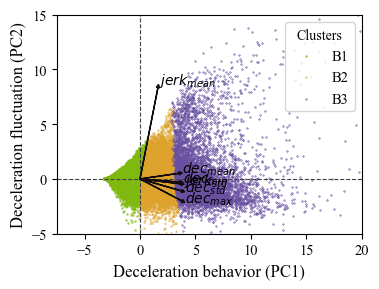

In [3]:
dec_data = pd.read_excel('../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_聚类结果.xlsx')
# 速度聚类模型保存
dec_dr = joblib.load('../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_降维模型.pkl')
for i in range(2):
    event = dec_data[dec_data['v_label'] == i]
    cls_list = list(event[['max_dec_lon', 'dec_label']].groupby(
        'dec_label').mean().sort_values(by='max_dec_lon').index)
    show_class_result(event, PC_list=['dec_PC1', 'dec_PC2'], label='dec_label',  pca=dec_dr.pca,
                      num_cls=3, feature_num=6,
                      arrow_text_list=[r'$dec_{max}$', r'$dec_{mean}$', r'$dec_{std}$',
                                       r'$dec_{min}$', r'$jerk_{mean}$', r'$jerk_{std}$'],
                      xy_labels=[
                          'Deceleration behavior (PC1)', 'Deceleration fluctuation (PC2)'],
                      cls_list=cls_list, cls_legend=['B1', 'B2', 'B3'],
                      cls_colors=['#7fb80e', '#dea32c', '#6950a1'],
                      vector_scale=1.5)
    plt.savefig(
        '../GpsFigure/两阶段聚类_New/二阶段刹车聚类/速度{}_减速相关指_聚类散点图.png'.format(i), dpi=1200)


In [ ]:
data = pd.read_excel('../GpsData/两阶段聚类_New/二阶段刹车聚类/减速相关指标_聚类结果.xlsx')

In [6]:
data.groupby(['v_label','dec_label'])['dec_label'].count()

v_label  dec_label
0        0            28432
         1             5772
         2            48660
1        0            42476
         1            54175
         2            10342
Name: dec_label, dtype: int64

In [7]:
data.groupby(['v_label','dec_label'])['max_dec_lon', 'mean_dec_lon', 'std_dec_lon','max_jerk', 'mean_jerk', 'std_jerk'].mean()

max_dec_lon  mean_dec_lon  std_dec_lon  max_jerk  \
v_label dec_label                                                     
0       0             1.017017      0.471297     0.327884  0.842556   
        1             1.840903      0.836720     0.679989  1.649784   
        2             0.493970      0.247978     0.140888  0.377803   
1       0             1.416246      0.662351     0.439988  1.049602   
        1             0.763959      0.385001     0.226220  0.555524   
        2             2.246782      1.015615     0.772344  1.878008   

                   mean_jerk  std_jerk  
v_label dec_label                       
0       0           0.102822  0.495185  
        1           0.254626  1.013803  
        2           0.038533  0.207897  
1       0           0.070098  0.608276  
        1           0.049431  0.318675  
        2           0.186352  1.151578

In [8]:
data.groupby(['v_label'])['dec_label'].count()

v_label
0     82864
1    106993
Name: dec_label, dtype: int64